# Figure 17.
| Author  | Stanley A. Baronett  |
|---------|----------------------|
| Created |  08/23/2025          |
| Updated |  08/23/2025          |

Similar to Figure 11 except for an optimized Athena++ model with $N_f = 3$ custom frequency bands (Section 4.5) and the corresponding band-mean opacities shown in Figure 16.

N_f	N_zeta			Relative Difference in T_eq(θ)
			30 deg			10 deg			0 deg
		3e-09 < τ < 2e-06	3e-05 < τ < 2e+02	5e-01 < τ < 2e+04
		Avg.	Max.		Avg.	Max.		Avg.	Max.
		(%)	(%)		(%)	(%)		(%)	(%)
(3)	(4)	(5)	(6)		(7)	(8)		(9)	(10)
3	4	9%	9%		7%	19%		11%	17%


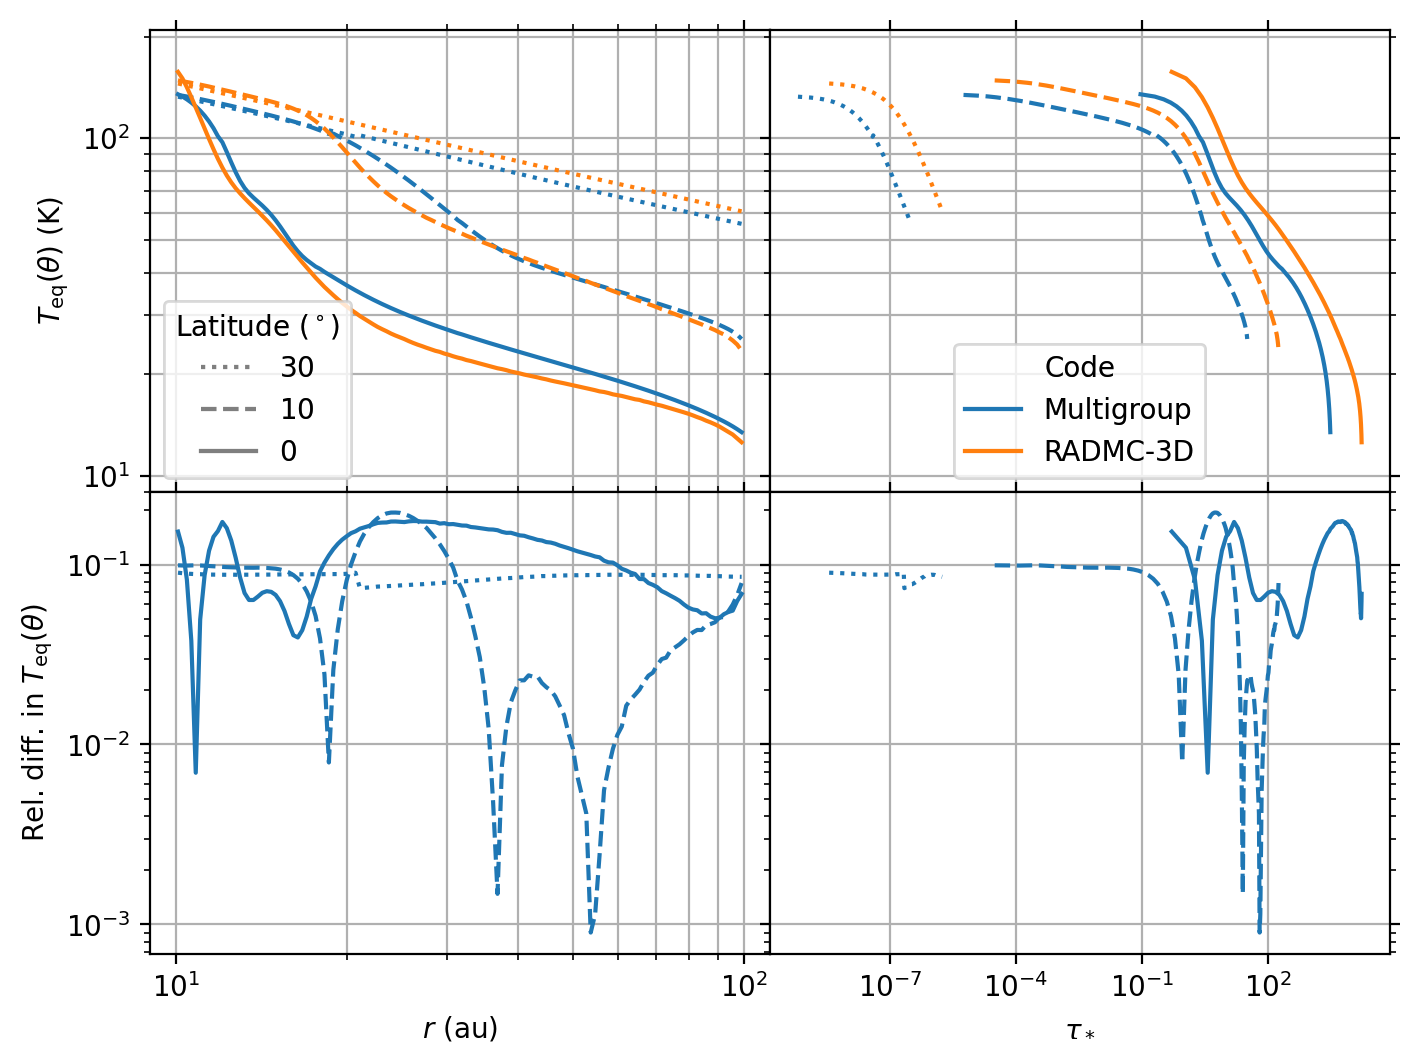

In [2]:
#===============================================================================
import athena_read
import matplotlib.pyplot as plt
import numpy as np

# Constants
au = 1.495978707e13           # astronomical unit [cm]
rad2deg = 180/np.pi

# Prepare plots
fig, axs = plt.subplots(nrows=2, ncols=2, sharex='col', sharey='row',
                        figsize=(8, 6), dpi=200)
lss = ['dotted', 'dashed', 'solid']
theta_degs = [60, 80, 90]
c_solns, ls_thetas = [], []

# RADMC-3D
root = '../radmc3d'
run = 'dsharp_abs-sca'
path = f'{root}/{run}'
grid = np.load(f'{path}/amr_grid.npz', allow_pickle=True)['grid'][()]
taux = np.load(f'{path}/taux.npz')['taux']
dusttemp = np.load(f'{path}/dust_temperature.npz')['dusttemp']

# Athena++
root = '../athena/models/dsharp_abs-sca/nfreq'
run = '3'
problem_id = 'dsharp'
print('N_f\tN_zeta\t\t\tRelative Difference in T_eq(θ)')
print(f'\t\t\t30 deg\t\t\t10 deg\t\t\t0 deg')
print(f'\t\t3e-09 < τ < 2e-06\t3e-05 < τ < 2e+02\t5e-01 < τ < 2e+04')
print(f'\t\tAvg.\tMax.\t\tAvg.\tMax.\t\tAvg.\tMax.')
print('\t\t(%)\t(%)\t\t(%)\t(%)\t\t(%)\t(%)')
print('(3)\t(4)\t(5)\t(6)\t\t(7)\t(8)\t\t(9)\t(10)')
avgs, maxs = [], []
path = f'{root}/{run}'
athinput = athena_read.athinput(f'{path}/athinput.{problem_id}')
length_unit = athinput['radiation']['length_unit']
t_unit = athinput['radiation']['T_unit']
l_au = length_unit/au
dtheta = (athinput['mesh']['x2max'] - athinput['mesh']['x2min'])\
          /athinput['mesh']['nx2']
athdf = athena_read.athdf(f'{path}/athdf/{problem_id}.out1.00001.athdf')
f_star = 2
dtau = (athdf[f'Sigma_a_{f_star}'][0] + athdf[f'Sigma_s_{f_star}'][0])\
       *np.diff(athdf['x1f'])
tau = np.cumsum(dtau, axis=1)
temps = athdf['press'][0]/athdf['rho'][0]
for th, theta_deg in enumerate(theta_degs):
    j = int(theta_deg/rad2deg/dtheta)
    rel_diff_temp = 2*np.abs(temps[j, :]*t_unit - dusttemp[:,j,0,0])\
                    /(temps[j, :]*t_unit + dusttemp[:,j,0,0])
    axs[0][0].plot(athdf['x1v']*l_au, temps[j, :]*t_unit, color='tab:blue',
                ls=lss[th])
    axs[0][0].plot(grid.x/au, dusttemp[:,j,0,0], color='tab:orange', ls=lss[th])
    axs[0][1].plot(tau[j, :], temps[j, :]*t_unit, color='tab:blue',
                   ls=lss[th])
    axs[0][1].plot(taux[:,j,0], dusttemp[:,j,0,0], color='tab:orange',
                   ls=lss[th])
    axs[1][0].plot(athdf['x1v']*l_au, rel_diff_temp, color='tab:blue',
                   ls=lss[th])
    axs[1][1].plot(taux[:,j,0], rel_diff_temp, color='tab:blue', ls=lss[th])
    ls_thetas.append(axs[0][1].plot([], [], color='tab:gray', ls=lss[th],
                 label=rf'${90-theta_deg}$')[0])
    avgs.append(np.mean(rel_diff_temp))
    maxs.append(np.max(rel_diff_temp))
print(f'{run}\t4\t{avgs[0]:.0%}\t{maxs[0]:.0%}\t\t{avgs[1]:.0%}\t'\
          +f'{maxs[1]:.0%}\t\t{avgs[2]:.0%}\t{maxs[2]:.0%}')
c_solns.append(axs[1][1].plot([], [], color='tab:blue', label=f'Multigroup')[0])
c_solns.append(axs[1][1].plot([], [], color='tab:orange', label='RADMC-3D')[0])

# Plot ghost points for colorless line style and add legends
axs[0][0].add_artist(axs[0][0].legend(framealpha=0.56, handles=ls_thetas,
                                      title=r'Latitude ($^\circ)$'))
axs[0][1].add_artist(axs[0][1].legend(framealpha=0.56, handles=c_solns,
                                      loc='lower center', title=r'Code'))

# Format plots
for ax in axs.flat:
    ax.grid()
    ax.minorticks_on()
    ax.set(xscale='log', yscale='log')
    ax.tick_params(axis='both', which='both', top=True, right=True)
axs[0][0].grid(axis='both', which='minor')
axs[0][1].grid(axis='y', which='minor')
axs[1][0].grid(axis='x', which='minor')
axs[0][0].set(ylabel=r'$T_\mathrm{eq}(\theta)$ (K)', ylim=(9, 2.1e2))
axs[1][0].set(xlabel=r'$r$ (au)',
              ylabel=r'Rel. diff. in $T_\mathrm{eq}(\theta)$')
axs[1][1].set(xlabel=r'$\tau_*$')
plt.subplots_adjust(hspace=0, wspace=0)
plt.savefig('figs/optimized_profiles.pdf', bbox_inches='tight', pad_inches=0.01)
#===============================================================================